# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=40,
        fold=3,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_13-47-43/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5156 | MulticlassF1Score=0.1326
Batch-30 : CrossEntropyLoss=2.4937 | MulticlassF1Score=0.1933
Batch-45 : CrossEntropyLoss=2.4685 | MulticlassF1Score=0.2157
Batch-60 : CrossEntropyLoss=2.5036 | MulticlassF1Score=0.2323
Batch-75 : CrossEntropyLoss=2.4316 | MulticlassF1Score=0.2557
Batch-90 : CrossEntropyLoss=2.4039 | MulticlassF1Score=0.2866
Batch-105: CrossEntropyLoss=2.4424 | MulticlassF1Score=0.3128
Batch-120: CrossEntropyLoss=2.3831 | MulticlassF1Score=0.3385
Batch-135: CrossEntropyLoss=2.3618 | MulticlassF1Score=0.3669
Batch-150: CrossEntropyLoss=2.3455 | MulticlassF1Score=0.3947
Batch-165: CrossEntropyLoss=2.3407 | MulticlassF1Score=0.4186
Batch-180: CrossEntropyLoss=2.3542 | MulticlassF1Score=0.4392
Batch-195: CrossEntropyLoss=2.3456 | MulticlassF1Score=0.4565
Batch-210: CrossEntropyLoss=2.3552 | MulticlassF1Score=0.4716
Batch-225: CrossEntropyLoss=2.3394 | MulticlassF1Score=0.4850
Batch-226: CrossEntropyLoss=2.3379 | MulticlassF1Score=0.4855

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3348 | MulticlassF1Score=0.6631
Batch-30 : CrossEntropyLoss=2.3328 | MulticlassF1Score=0.6688
Batch-45 : CrossEntropyLoss=2.3449 | MulticlassF1Score=0.6703
Batch-60 : CrossEntropyLoss=2.3505 | MulticlassF1Score=0.6710
Batch-63 : CrossEntropyLoss=2.3399 | MulticlassF1Score=0.6707

Training   : Mean CrossEntropyLoss = 2.4190 | Mean MulticlassF1Score = 0.3230
Validation : Mean CrossEntropyLoss = 2.3500 | Mean MulticlassF1Score = 0.6668

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3460 | MulticlassF1Score=0.6883
Batch-30 : CrossEntropyLoss=2.3353 | MulticlassF1Score=0.6923
Batch-45 : CrossEntropyLoss=2.3493 | MulticlassF1Score=0.6986
Batch-60 : CrossEntropyLoss=2.3322 | MulticlassF1Score=0.7020
Batch-75 : CrossEntropyLoss=2.3438 | MulticlassF1Score=0.7045
Batch-90 : CrossEntropyLoss=2.3282 | MulticlassF1Score=0.7069
Batch-105: CrossEntropyLoss=2.3284 | MulticlassF1Score=0.7080
Batch-120: CrossEntropyLoss=2.3309 | MulticlassF1Score=0.7089
Batch-135: CrossEntropyLoss=2.3408 | MulticlassF1Score=0.7094
Batch-150: CrossEntropyLoss=2.3243 | MulticlassF1Score=0.7101
Batch-165: CrossEntropyLoss=2.3391 | MulticlassF1Score=0.7109
Batch-180: CrossEntropyLoss=2.3439 | MulticlassF1Score=0.7113
Batch-195: CrossEntropyLoss=2.3339 | MulticlassF1Score=0.7121
Batch-210: CrossEntropyLoss=2.3385 | MulticlassF1Score=0.7119
Batch-225: CrossEntropyLoss=2.3293 | MulticlassF1Score=0.7137
Batch-226: CrossEntropyLoss=2.3234 | MulticlassF1Score=0.7140

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3235 | MulticlassF1Score=0.7734
Batch-30 : CrossEntropyLoss=2.3181 | MulticlassF1Score=0.7749
Batch-45 : CrossEntropyLoss=2.3211 | MulticlassF1Score=0.7767
Batch-60 : CrossEntropyLoss=2.3234 | MulticlassF1Score=0.7749
Batch-63 : CrossEntropyLoss=2.3092 | MulticlassF1Score=0.7747

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3375 | Mean MulticlassF1Score = 0.7043
Validation : Mean CrossEntropyLoss = 2.3194 | Mean MulticlassF1Score = 0.7758

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3263 | MulticlassF1Score=0.7728
Batch-30 : CrossEntropyLoss=2.3054 | MulticlassF1Score=0.7809
Batch-45 : CrossEntropyLoss=2.3144 | MulticlassF1Score=0.7811
Batch-60 : CrossEntropyLoss=2.3265 | MulticlassF1Score=0.7814
Batch-75 : CrossEntropyLoss=2.3124 | MulticlassF1Score=0.7816
Batch-90 : CrossEntropyLoss=2.3121 | MulticlassF1Score=0.7828
Batch-105: CrossEntropyLoss=2.3122 | MulticlassF1Score=0.7829
Batch-120: CrossEntropyLoss=2.3227 | MulticlassF1Score=0.7831
Batch-135: CrossEntropyLoss=2.3151 | MulticlassF1Score=0.7834
Batch-150: CrossEntropyLoss=2.3061 | MulticlassF1Score=0.7842
Batch-165: CrossEntropyLoss=2.3038 | MulticlassF1Score=0.7856
Batch-180: CrossEntropyLoss=2.3018 | MulticlassF1Score=0.7875
Batch-195: CrossEntropyLoss=2.3091 | MulticlassF1Score=0.7898
Batch-210: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.7926
Batch-225: CrossEntropyLoss=2.3000 | MulticlassF1Score=0.7949
Batch-226: CrossEntropyLoss=2.3079 | MulticlassF1Score=0.7949

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8294
Batch-30 : CrossEntropyLoss=2.3096 | MulticlassF1Score=0.8261
Batch-45 : CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8263
Batch-60 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8262
Batch-63 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8267

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3120 | Mean MulticlassF1Score = 0.7841
Validation : Mean CrossEntropyLoss = 2.3020 | Mean MulticlassF1Score = 0.8283

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8393
Batch-30 : CrossEntropyLoss=2.3071 | MulticlassF1Score=0.8336
Batch-45 : CrossEntropyLoss=2.3074 | MulticlassF1Score=0.8294
Batch-60 : CrossEntropyLoss=2.3154 | MulticlassF1Score=0.8302
Batch-75 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8298
Batch-90 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8290
Batch-105: CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8292
Batch-120: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8280
Batch-135: CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8292
Batch-150: CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8291
Batch-165: CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8286
Batch-180: CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8284
Batch-195: CrossEntropyLoss=2.3168 | MulticlassF1Score=0.8284
Batch-210: CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8282
Batch-225: CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8282
Batch-226: CrossEntropyLoss=2.3130 | MulticlassF1Score=0.8281

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3082 | MulticlassF1Score=0.8299
Batch-30 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8291
Batch-45 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8290
Batch-60 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8297
Batch-63 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8291

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3013 | Mean MulticlassF1Score = 0.8306
Validation : Mean CrossEntropyLoss = 2.3008 | Mean MulticlassF1Score = 0.8301

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8333
Batch-30 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8317
Batch-45 : CrossEntropyLoss=2.3104 | MulticlassF1Score=0.8317
Batch-60 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8324
Batch-75 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8318
Batch-90 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8308
Batch-105: CrossEntropyLoss=2.3103 | MulticlassF1Score=0.8300
Batch-120: CrossEntropyLoss=2.3078 | MulticlassF1Score=0.8300
Batch-135: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8303
Batch-150: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8306
Batch-165: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8307
Batch-180: CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8310
Batch-195: CrossEntropyLoss=2.3062 | MulticlassF1Score=0.8312
Batch-210: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8307
Batch-225: CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8303
Batch-226: CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8303

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8274
Batch-30 : CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8300
Batch-45 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8295
Batch-60 : CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8290
Batch-63 : CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8295

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3004 | Mean MulticlassF1Score = 0.8310
Validation : Mean CrossEntropyLoss = 2.3005 | Mean MulticlassF1Score = 0.8284

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8343
Batch-30 : CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8304
Batch-45 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8291
Batch-60 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8306
Batch-75 : CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8318
Batch-90 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8314
Batch-105: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8323
Batch-120: CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8321
Batch-135: CrossEntropyLoss=2.3136 | MulticlassF1Score=0.8314
Batch-150: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8322
Batch-165: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8324
Batch-180: CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8321
Batch-195: CrossEntropyLoss=2.3063 | MulticlassF1Score=0.8321
Batch-210: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8320
Batch-225: CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8320
Batch-226: CrossEntropyLoss=2.3072 | MulticlassF1Score=0.8320

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8197
Batch-30 : CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8278
Batch-45 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8279
Batch-60 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8298
Batch-63 : CrossEntropyLoss=2.3175 | MulticlassF1Score=0.8300

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2998 | Mean MulticlassF1Score = 0.8318
Validation : Mean CrossEntropyLoss = 2.3005 | Mean MulticlassF1Score = 0.8236

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8393
Batch-30 : CrossEntropyLoss=2.3119 | MulticlassF1Score=0.8352
Batch-45 : CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8335
Batch-60 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8337
Batch-75 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8338
Batch-90 : CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8332
Batch-105: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8329
Batch-120: CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8325
Batch-135: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8328
Batch-150: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8338
Batch-165: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8339
Batch-180: CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8335
Batch-195: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8332
Batch-210: CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8332
Batch-225: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8331
Batch-226: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8332

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8244
Batch-30 : CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8277
Batch-45 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8304
Batch-60 : CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8304
Batch-63 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8303

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2993 | Mean MulticlassF1Score = 0.8342
Validation : Mean CrossEntropyLoss = 2.3002 | Mean MulticlassF1Score = 0.8297

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8381
Batch-30 : CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8355
Batch-45 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8350
Batch-60 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8345
Batch-75 : CrossEntropyLoss=2.3101 | MulticlassF1Score=0.8349
Batch-90 : CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8365
Batch-105: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8388
Batch-120: CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8396
Batch-135: CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8405
Batch-150: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8411
Batch-165: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8422
Batch-180: CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8427
Batch-195: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8437
Batch-210: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8443
Batch-225: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8449
Batch-226: CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8449

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8482
Batch-30 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8457
Batch-45 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8465
Batch-60 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8481
Batch-63 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8482

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2960 | Mean MulticlassF1Score = 0.8397
Validation : Mean CrossEntropyLoss = 2.2948 | Mean MulticlassF1Score = 0.8462

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8520
Batch-30 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8511
Batch-45 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8522
Batch-60 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8530
Batch-75 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8538
Batch-90 : CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8536
Batch-105: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8533
Batch-120: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8536
Batch-135: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8532
Batch-150: CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8534
Batch-165: CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8531
Batch-180: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8534
Batch-195: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8529
Batch-210: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8525
Batch-225: CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8529
Batch-226: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8529

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8468
Batch-30 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8457
Batch-45 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8473
Batch-60 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8478
Batch-63 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8480

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2934 | Mean MulticlassF1Score = 0.8529
Validation : Mean CrossEntropyLoss = 2.2948 | Mean MulticlassF1Score = 0.8468

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8522
Batch-30 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8532
Batch-45 : CrossEntropyLoss=2.3079 | MulticlassF1Score=0.8502
Batch-60 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8505
Batch-75 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8512
Batch-90 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8543
Batch-105: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8567
Batch-120: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8601
Batch-135: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8629
Batch-150: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8651
Batch-165: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8669
Batch-180: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8683
Batch-195: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8695
Batch-210: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8708
Batch-225: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8720
Batch-226: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8721

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8789
Batch-30 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8777
Batch-45 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8773
Batch-60 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8798
Batch-63 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8800

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2877 | Mean MulticlassF1Score = 0.8600
Validation : Mean CrossEntropyLoss = 2.2851 | Mean MulticlassF1Score = 0.8783

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8846
Batch-30 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8887
Batch-45 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8906
Batch-60 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8890
Batch-75 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8890
Batch-90 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8894
Batch-105: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8894
Batch-120: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8890
Batch-135: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8884
Batch-150: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8883
Batch-165: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8885
Batch-180: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8886
Batch-195: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8886
Batch-210: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8886
Batch-225: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8886
Batch-226: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8885

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8855
Batch-30 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8842
Batch-45 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8831
Batch-60 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8824
Batch-63 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8826

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2825 | Mean MulticlassF1Score = 0.8886
Validation : Mean CrossEntropyLoss = 2.2842 | Mean MulticlassF1Score = 0.8830

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8918
Batch-30 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8919
Batch-45 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8918
Batch-60 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8919
Batch-75 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8913
Batch-90 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8920
Batch-105: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8916
Batch-120: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8921
Batch-135: CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8925
Batch-150: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8922
Batch-165: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8919
Batch-180: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8919
Batch-195: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8915
Batch-210: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8913
Batch-225: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8913
Batch-226: CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8912

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8799
Batch-30 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8827
Batch-45 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8820
Batch-60 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8828
Batch-63 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8831

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2816 | Mean MulticlassF1Score = 0.8914
Validation : Mean CrossEntropyLoss = 2.2840 | Mean MulticlassF1Score = 0.8816

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8957
Batch-30 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8967
Batch-45 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.8959
Batch-60 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8964
Batch-75 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8958
Batch-90 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8954
Batch-105: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8949
Batch-120: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8947
Batch-135: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8945
Batch-150: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8945
Batch-165: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8943
Batch-180: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8940
Batch-195: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8938
Batch-210: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8936
Batch-225: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8937
Batch-226: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.8938

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8866
Batch-30 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8825
Batch-45 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8833
Batch-60 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8840
Batch-63 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8841

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2807 | Mean MulticlassF1Score = 0.8953
Validation : Mean CrossEntropyLoss = 2.2836 | Mean MulticlassF1Score = 0.8842

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8955
Batch-30 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8961
Batch-45 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8957
Batch-60 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8971
Batch-75 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8981
Batch-90 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.8975
Batch-105: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8966
Batch-120: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8966
Batch-135: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.8968
Batch-150: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8966
Batch-165: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8960
Batch-180: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8961
Batch-195: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8960
Batch-210: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8960
Batch-225: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8959
Batch-226: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8959

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8887
Batch-30 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8871
Batch-45 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8877
Batch-60 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8868
Batch-63 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8866

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2800 | Mean MulticlassF1Score = 0.8966
Validation : Mean CrossEntropyLoss = 2.2828 | Mean MulticlassF1Score = 0.8895

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8996
Batch-30 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9019
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9030
Batch-60 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.9034
Batch-75 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9051
Batch-90 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9075
Batch-105: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9095
Batch-120: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9109
Batch-135: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9120
Batch-150: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9136
Batch-165: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9151
Batch-180: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9157
Batch-195: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9162
Batch-210: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9168
Batch-225: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9173
Batch-226: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9173

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9103
Batch-30 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9103
Batch-45 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9111
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9122
Batch-63 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9122

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2736 | Mean MulticlassF1Score = 0.9091
Validation : Mean CrossEntropyLoss = 2.2751 | Mean MulticlassF1Score = 0.9107

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9269
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9269
Batch-45 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9276
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9264
Batch-75 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9266
Batch-90 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9266
Batch-105: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9261
Batch-120: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9262
Batch-135: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9260
Batch-150: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9259
Batch-165: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9258
Batch-180: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9259
Batch-195: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9259
Batch-210: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9259
Batch-225: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9259
Batch-226: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9259

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9145
Batch-30 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9117
Batch-45 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9127
Batch-60 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9122
Batch-63 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.9119

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9263
Validation : Mean CrossEntropyLoss = 2.2751 | Mean MulticlassF1Score = 0.9130

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9266
Batch-30 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9259
Batch-45 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9272
Batch-60 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9277
Batch-75 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9271
Batch-90 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9270
Batch-105: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9267
Batch-120: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9272
Batch-135: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9269
Batch-150: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9267
Batch-165: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9268
Batch-180: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9270
Batch-195: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9271
Batch-210: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9271
Batch-225: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9268
Batch-226: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9268

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9147
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9126
Batch-45 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.9119
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9131
Batch-63 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9127

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9270
Validation : Mean CrossEntropyLoss = 2.2747 | Mean MulticlassF1Score = 0.9128

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9266
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9276
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9280
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9294
Batch-75 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9281
Batch-90 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9278
Batch-105: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9278
Batch-120: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9273
Batch-135: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9274
Batch-150: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9274
Batch-165: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9275
Batch-180: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9278
Batch-195: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9278
Batch-210: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9275
Batch-225: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9276
Batch-226: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9276

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9099
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9131
Batch-45 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9127
Batch-60 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.9130
Batch-63 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9129

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9278
Validation : Mean CrossEntropyLoss = 2.2746 | Mean MulticlassF1Score = 0.9118

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9284
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9290
Batch-45 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9294
Batch-60 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9295
Batch-75 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9299
Batch-90 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9290
Batch-105: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9289
Batch-120: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9283
Batch-135: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9289
Batch-150: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9293
Batch-165: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9294
Batch-180: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9295
Batch-195: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9290
Batch-210: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9288
Batch-225: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9290
Batch-226: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9291

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9119
Batch-30 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9123
Batch-45 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9133
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9133
Batch-63 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9131

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2696 | Mean MulticlassF1Score = 0.9292
Validation : Mean CrossEntropyLoss = 2.2744 | Mean MulticlassF1Score = 0.9134

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9347
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9340
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9327
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9316
Batch-75 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9303
Batch-90 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9306
Batch-105: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9305
Batch-120: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9302
Batch-135: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9300
Batch-150: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9300
Batch-165: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9303
Batch-180: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9303
Batch-195: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9302
Batch-210: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9300
Batch-225: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9298
Batch-226: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9298

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9153
Batch-30 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9151
Batch-45 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9140
Batch-60 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9139
Batch-63 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9139

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2693 | Mean MulticlassF1Score = 0.9309
Validation : Mean CrossEntropyLoss = 2.2743 | Mean MulticlassF1Score = 0.9149

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9318
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9312
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9307
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9307
Batch-75 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9304
Batch-90 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9296
Batch-105: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9298
Batch-120: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9304
Batch-135: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9304
Batch-150: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9300
Batch-165: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9301
Batch-180: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9302
Batch-195: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9302
Batch-210: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9304
Batch-225: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9303
Batch-226: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9304

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9171
Batch-30 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9135
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9145
Batch-60 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9143
Batch-63 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9139

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2691 | Mean MulticlassF1Score = 0.9302
Validation : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9147

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9305
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9283
Batch-45 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9269
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9275
Batch-75 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9284
Batch-90 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9292
Batch-105: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9291
Batch-120: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9293
Batch-135: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9297
Batch-150: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9299
Batch-165: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9301
Batch-180: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9305
Batch-195: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9305
Batch-210: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9304
Batch-225: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9308
Batch-226: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9309

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9152
Batch-30 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9151
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9147
Batch-60 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9138
Batch-63 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9140

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2689 | Mean MulticlassF1Score = 0.9293
Validation : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9142

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9289
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9308
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9314
Batch-60 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9307
Batch-75 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9301
Batch-90 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9296
Batch-105: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9297
Batch-120: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9299
Batch-135: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9300
Batch-150: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9308
Batch-165: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9313
Batch-180: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9311
Batch-195: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9313
Batch-210: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9308
Batch-225: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9310
Batch-226: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9310

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9173
Batch-30 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9154
Batch-45 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9150
Batch-60 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9142
Batch-63 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9141

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2688 | Mean MulticlassF1Score = 0.9305
Validation : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9149

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9313
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9319
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9323
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9322
Batch-75 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9319
Batch-90 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9321
Batch-105: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9318
Batch-120: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9316
Batch-135: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9314
Batch-150: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9314
Batch-165: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9315
Batch-180: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9318
Batch-195: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9313
Batch-210: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9312
Batch-225: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9311
Batch-226: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9311

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9118
Batch-30 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9121
Batch-45 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9144
Batch-60 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9138
Batch-63 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9137

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2688 | Mean MulticlassF1Score = 0.9315
Validation : Mean CrossEntropyLoss = 2.2743 | Mean MulticlassF1Score = 0.9124
Patience = 1/50❗

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9329
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9325
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9324
Batch-60 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9327
Batch-75 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9321
Batch-90 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9316
Batch-105: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9313
Batch-120: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9315
Batch-135: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9314
Batch-150: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9317
Batch-165: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9315
Batch-180: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9314
Batch-195: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9315
Batch-210: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9314
Batch-225: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9313
Batch-226: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9313

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9086
Batch-30 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9108
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9124
Batch-60 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9125
Batch-63 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9126

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2688 | Mean MulticlassF1Score = 0.9318
Validation : Mean CrossEntropyLoss = 2.2746 | Mean MulticlassF1Score = 0.9120

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9338
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9308
Batch-45 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9316
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9319
Batch-75 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9319
Batch-90 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9312
Batch-105: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9312
Batch-120: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9311
Batch-135: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9313
Batch-150: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9312
Batch-165: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9308
Batch-180: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9308
Batch-195: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9306
Batch-210: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9306
Batch-225: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9305
Batch-226: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9306

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9125
Batch-30 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9118
Batch-45 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9133
Batch-60 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9143
Batch-63 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9137

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2690 | Mean MulticlassF1Score = 0.9313
Validation : Mean CrossEntropyLoss = 2.2743 | Mean MulticlassF1Score = 0.9127
Patience = 2/50❗

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9298
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9321
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9316
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9323
Batch-75 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9321
Batch-90 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9323
Batch-105: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9324
Batch-120: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9320
Batch-135: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9322
Batch-150: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9321
Batch-165: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9324
Batch-180: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9324
Batch-195: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9320
Batch-210: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9319
Batch-225: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9316
Batch-226: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9316

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9109
Batch-30 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9129
Batch-45 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9144
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9138
Batch-63 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9140

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2687 | Mean MulticlassF1Score = 0.9323
Validation : Mean CrossEntropyLoss = 2.2741 | Mean MulticlassF1Score = 0.9123

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9356
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9359
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9341
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9345
Batch-75 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9339
Batch-90 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9332
Batch-105: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9327
Batch-120: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9329
Batch-135: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9335
Batch-150: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9331
Batch-165: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9329
Batch-180: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9326
Batch-195: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9324
Batch-210: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9321
Batch-225: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9323
Batch-226: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9323

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9160
Batch-30 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9140
Batch-45 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9147
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9138
Batch-63 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9137

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2684 | Mean MulticlassF1Score = 0.9337
Validation : Mean CrossEntropyLoss = 2.2741 | Mean MulticlassF1Score = 0.9142

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9313
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9321
Batch-45 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9316
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9322
Batch-75 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9326
Batch-90 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9339
Batch-105: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9337
Batch-120: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9338
Batch-135: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9343
Batch-150: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9349
Batch-165: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9355
Batch-180: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9357
Batch-195: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9360
Batch-210: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9366
Batch-225: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9366
Batch-226: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9367

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9239
Batch-30 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9212
Batch-45 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9220
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9225
Batch-63 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9222

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9340
Validation : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9224

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9387
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9412
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9409
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9407
Batch-75 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9409
Batch-90 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9410
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9405
Batch-120: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9406
Batch-135: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9404
Batch-150: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9406
Batch-165: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9405
Batch-180: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9404
Batch-195: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9404
Batch-210: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9406
Batch-225: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9404
Batch-226: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9405

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9214
Batch-30 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9223
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9217
Batch-60 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9217
Batch-63 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9218

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9405
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9219

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9397
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9407
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9397
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9402
Batch-75 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9405
Batch-90 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9407
Batch-105: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9407
Batch-120: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9410
Batch-135: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9412
Batch-150: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9413
Batch-165: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9411
Batch-180: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9410
Batch-195: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9410
Batch-210: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9409
Batch-225: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9409
Batch-226: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9409

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9260
Batch-30 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9231
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9226
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9232
Batch-63 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9224

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9404
Validation : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9237

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9409
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9403
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9411
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9411
Batch-75 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9415
Batch-90 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9408
Batch-105: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9408
Batch-120: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9410
Batch-135: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9407
Batch-150: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9406
Batch-165: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9409
Batch-180: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9411
Batch-195: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9409
Batch-210: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9410
Batch-225: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9413
Batch-226: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9414

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9381
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9377
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9365
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9362
Batch-63 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9359

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9409
Validation : Mean CrossEntropyLoss = 2.2676 | Mean MulticlassF1Score = 0.9371

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9570
Batch-30 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9600
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9601
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9604
Batch-75 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9602
Batch-90 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9603
Batch-105: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9604
Batch-120: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9602
Batch-135: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9600
Batch-150: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9601
Batch-165: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9598
Batch-180: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9597
Batch-195: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9596
Batch-210: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9597
Batch-225: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9598
Batch-226: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9598

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9389
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9414
Batch-45 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9408
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9408
Batch-63 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9411

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2601 | Mean MulticlassF1Score = 0.9597
Validation : Mean CrossEntropyLoss = 2.2658 | Mean MulticlassF1Score = 0.9407

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9637
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9610
Batch-45 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9620
Batch-60 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9624
Batch-75 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9628
Batch-90 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9626
Batch-105: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9629
Batch-120: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9623
Batch-135: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9623
Batch-150: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9619
Batch-165: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9618
Batch-180: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9617
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9615
Batch-210: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9611
Batch-225: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9609
Batch-226: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9609

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9416
Batch-30 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9415
Batch-45 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9412
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9415
Batch-63 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9416

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2596 | Mean MulticlassF1Score = 0.9622
Validation : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9411

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9624
Batch-30 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9599
Batch-45 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9599
Batch-60 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9613
Batch-75 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9621
Batch-90 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9619
Batch-105: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9617
Batch-120: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9613
Batch-135: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9616
Batch-150: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9617
Batch-165: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9615
Batch-180: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9612
Batch-195: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9612
Batch-210: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9612
Batch-225: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9612
Batch-226: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9612

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9418
Batch-30 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9412
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9419
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9411
Batch-63 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9415

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2595 | Mean MulticlassF1Score = 0.9612
Validation : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9425

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9641
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9619
Batch-45 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9624
Batch-60 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9618
Batch-75 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9620
Batch-90 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9620
Batch-105: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9618
Batch-120: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9619
Batch-135: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9617
Batch-150: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9621
Batch-165: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9619
Batch-180: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9618
Batch-195: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9616
Batch-210: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9616
Batch-225: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9614
Batch-226: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9614

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9422
Batch-30 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9422
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9428
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9426
Batch-63 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9423

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2594 | Mean MulticlassF1Score = 0.9621
Validation : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9423

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9620
Batch-30 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9595
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9614
Batch-60 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9623
Batch-75 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9619
Batch-90 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9624
Batch-105: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9623
Batch-120: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9619
Batch-135: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9620
Batch-150: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9618
Batch-165: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9619
Batch-180: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9621
Batch-195: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9622
Batch-210: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9621
Batch-225: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9620
Batch-226: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9620

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9387
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9411
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9416
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9412
Batch-63 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9412

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2592 | Mean MulticlassF1Score = 0.9619
Validation : Mean CrossEntropyLoss = 2.2658 | Mean MulticlassF1Score = 0.9403

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9635
Batch-30 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9634
Batch-45 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9618
Batch-60 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9617
Batch-75 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9619
Batch-90 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9619
Batch-105: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9622
Batch-120: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9619
Batch-135: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9617
Batch-150: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9620
Batch-165: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9621
Batch-180: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9623
Batch-195: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9625
Batch-210: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9624
Batch-225: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9622
Batch-226: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9623

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9413
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9408
Batch-45 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9417
Batch-60 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9422
Batch-63 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9421

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2591 | Mean MulticlassF1Score = 0.9622
Validation : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9414

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9600
Batch-30 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9604
Batch-45 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9606
Batch-60 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9619
Batch-75 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9625
Batch-90 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9625
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9630
Batch-120: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9629
Batch-135: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9628
Batch-150: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9627
Batch-165: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9626
Batch-180: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9624
Batch-195: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9624
Batch-210: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9623
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9624
Batch-226: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9623

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9413
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9422
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9426
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9422
Batch-63 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9420

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2591 | Mean MulticlassF1Score = 0.9620
Validation : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9418

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9630
Batch-30 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9623
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9621
Batch-60 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9630
Batch-75 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9634
Batch-90 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9636
Batch-105: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9630
Batch-120: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9630
Batch-135: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9627
Batch-150: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9626
Batch-165: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9626
Batch-180: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9626
Batch-195: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9625
Batch-210: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9624
Batch-225: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9623
Batch-226: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9622

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9402
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9417
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9418
Batch-60 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9418
Batch-63 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9418

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2591 | Mean MulticlassF1Score = 0.9628
Validation : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9407
Patience = 3/50❗

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9648
Batch-30 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9634
Batch-45 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9641
Batch-60 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9640
Batch-75 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9635
Batch-90 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9630
Batch-105: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9632
Batch-120: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9628
Batch-135: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9625
Batch-150: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9623
Batch-165: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9625
Batch-180: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9623
Batch-195: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9622
Batch-210: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9623
Batch-225: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9624
Batch-226: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9623

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9404
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9433
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9423
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9422
Batch-63 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9422

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2591 | Mean MulticlassF1Score = 0.9630
Validation : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9416

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9632
Batch-30 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9627
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9624
Batch-60 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9616
Batch-75 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9616
Batch-90 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9612
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9614
Batch-120: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9615
Batch-135: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9615
Batch-150: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9615
Batch-165: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9617
Batch-180: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9619
Batch-195: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9622
Batch-210: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9622
Batch-225: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9624
Batch-226: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9623

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9411
Batch-30 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9418
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9415
Batch-60 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9415
Batch-63 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9413

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2591 | Mean MulticlassF1Score = 0.9618
Validation : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9409

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9649
Batch-30 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9643
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9642
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9646
Batch-75 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9627
Batch-90 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9629
Batch-105: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9628
Batch-120: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9627
Batch-135: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9627
Batch-150: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9626
Batch-165: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9626
Batch-180: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9627
Batch-195: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9625
Batch-210: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9625
Batch-225: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9625
Batch-226: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9625

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9433
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9432
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9421
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9413
Batch-63 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9415

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2590 | Mean MulticlassF1Score = 0.9633
Validation : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9422

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9623
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9628
Batch-45 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9631
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9633
Batch-75 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9631
Batch-90 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9631
Batch-105: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9629
Batch-120: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9626
Batch-135: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9627
Batch-150: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9627
Batch-165: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9627
Batch-180: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9627
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9625
Batch-210: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9626
Batch-225: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9625
Batch-226: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9625

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9438
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9420
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9424
Batch-60 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9421
Batch-63 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9420

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2590 | Mean MulticlassF1Score = 0.9629
Validation : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9419

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9592
Batch-30 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9594
Batch-45 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9572
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9577
Batch-75 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9579
Batch-90 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9576
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9577
Batch-120: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9575
Batch-135: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9576
Batch-150: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9577
Batch-165: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9578
Batch-180: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9579
Batch-195: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9580
Batch-210: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9581
Batch-225: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9581
Batch-226: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9581

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9419
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9417
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9404
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9395
Batch-63 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9395

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2605 | Mean MulticlassF1Score = 0.9580
Validation : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9418
Patience = 4/50❗

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9619
Batch-30 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9603
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9608
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9613
Batch-75 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9613
Batch-90 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9613
Batch-105: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9611
Batch-120: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9612
Batch-135: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9612
Batch-150: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9613
Batch-165: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9613
Batch-180: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9614
Batch-195: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9612
Batch-210: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9610
Batch-225: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9609
Batch-226: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9610

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9390
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9376
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9396
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9415
Batch-63 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9418

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2596 | Mean MulticlassF1Score = 0.9611
Validation : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9388

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9622
Batch-30 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9627
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9623
Batch-60 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9620
Batch-75 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9626
Batch-90 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9619
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9617
Batch-120: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9621
Batch-135: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9618
Batch-150: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9620
Batch-165: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9618
Batch-180: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9619
Batch-195: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9621
Batch-210: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9622
Batch-225: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9624
Batch-226: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9624

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9390
Batch-30 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9400
Batch-45 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9393
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9409
Batch-63 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9413

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2591 | Mean MulticlassF1Score = 0.9621
Validation : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9386

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9641
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9627
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9626
Batch-60 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9629
Batch-75 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9626
Batch-90 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9627
Batch-105: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9631
Batch-120: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9628
Batch-135: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9630
Batch-150: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9630
Batch-165: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9631
Batch-180: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9630
Batch-195: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9632
Batch-210: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9632
Batch-225: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9633
Batch-226: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9633

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9423
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9418
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9417
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9414
Batch-63 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9411

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2588 | Mean MulticlassF1Score = 0.9631
Validation : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9418

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9631
Batch-30 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9633
Batch-45 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9638
Batch-60 : CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9639
Batch-75 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9641
Batch-90 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9637
Batch-105: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9634
Batch-120: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9634
Batch-135: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9636
Batch-150: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9636
Batch-165: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9636
Batch-180: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9637
Batch-195: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9638
Batch-210: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9636
Batch-225: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9638
Batch-226: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9637

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9448
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9433
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9429
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9421
Batch-63 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9421

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2586 | Mean MulticlassF1Score = 0.9636
Validation : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9432

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9649
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9653
Batch-45 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9664
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9659
Batch-75 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9656
Batch-90 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9652
Batch-105: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9647
Batch-120: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9646
Batch-135: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9642
Batch-150: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9643
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9646
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9648
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9646
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9644
Batch-225: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9641
Batch-226: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9642

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9445
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9436
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9433
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9419
Batch-63 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9418

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9650
Validation : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9438

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2584
Best CrossEntropyLoss training    : 2.2655
Best MulticlassF1Score validation : 0.9650
Best MulticlassF1Score validation : 0.9438
Training duration                 : 2.3182 minutes.
Training date                     : 2022-10-19 10:18:04.665209+08:00


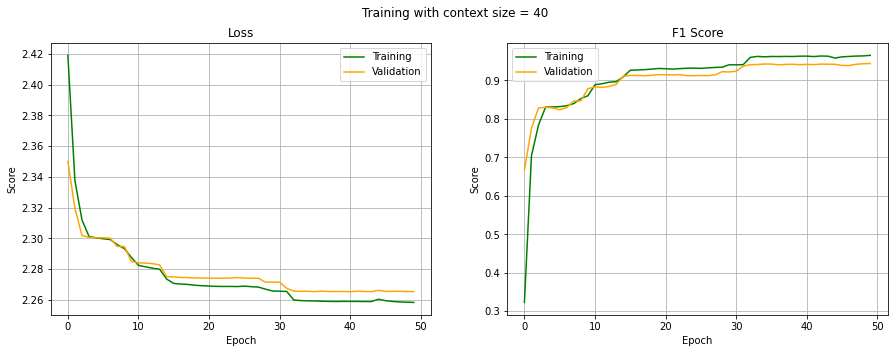

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9646, device='cuda:0'),
 tensor(0.9418, device='cuda:0'),
 tensor(0.9407, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9646, device='cuda:0'),
 tensor(0.9418, device='cuda:0'),
 tensor(0.9407, device='cuda:0'))

## Heatmap

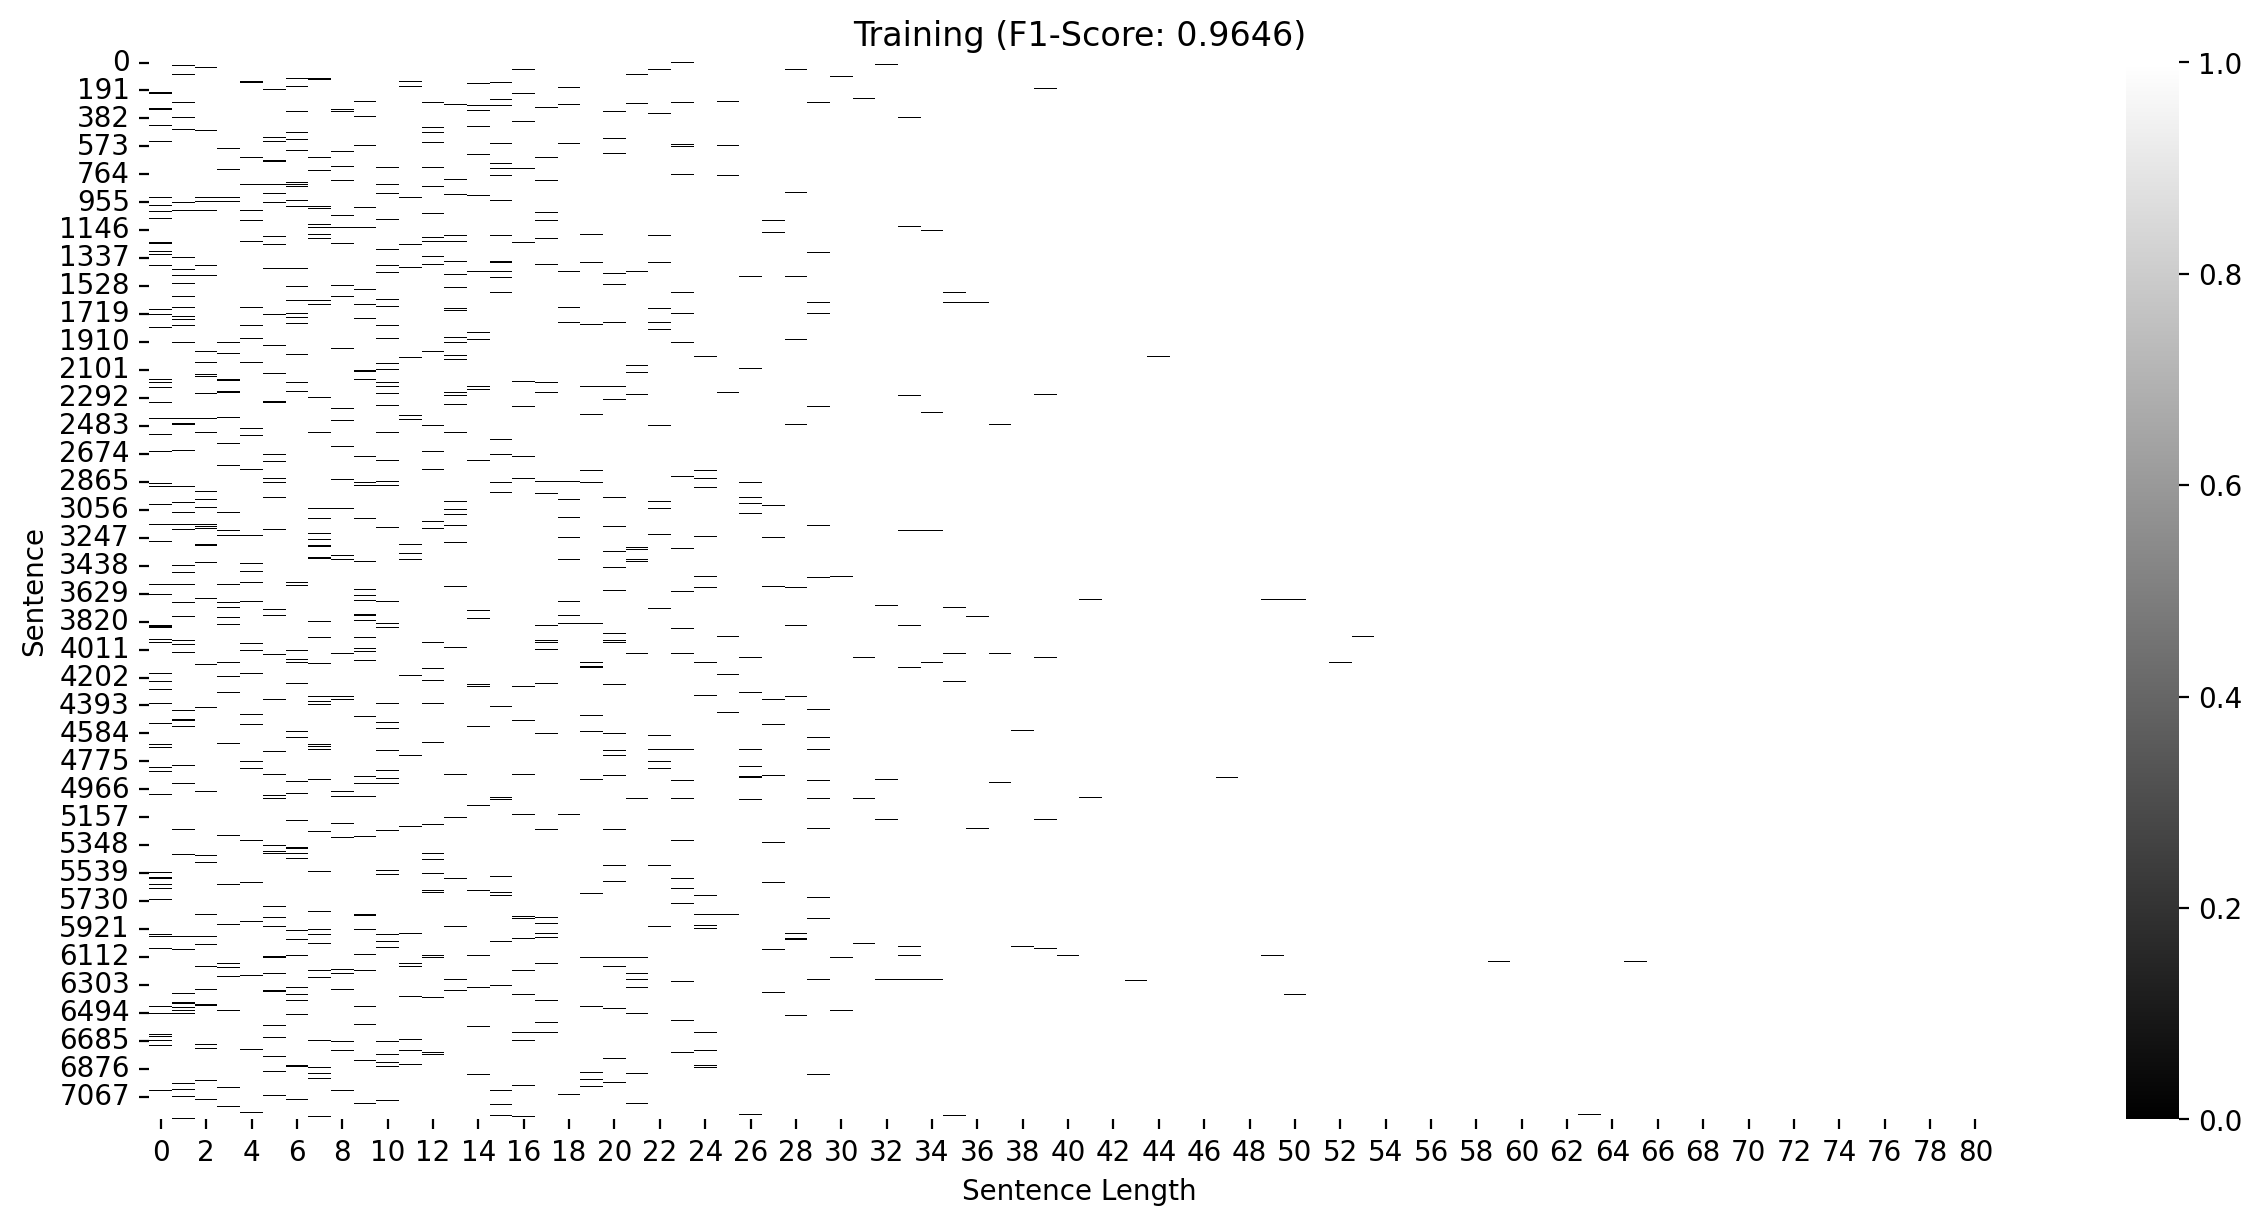

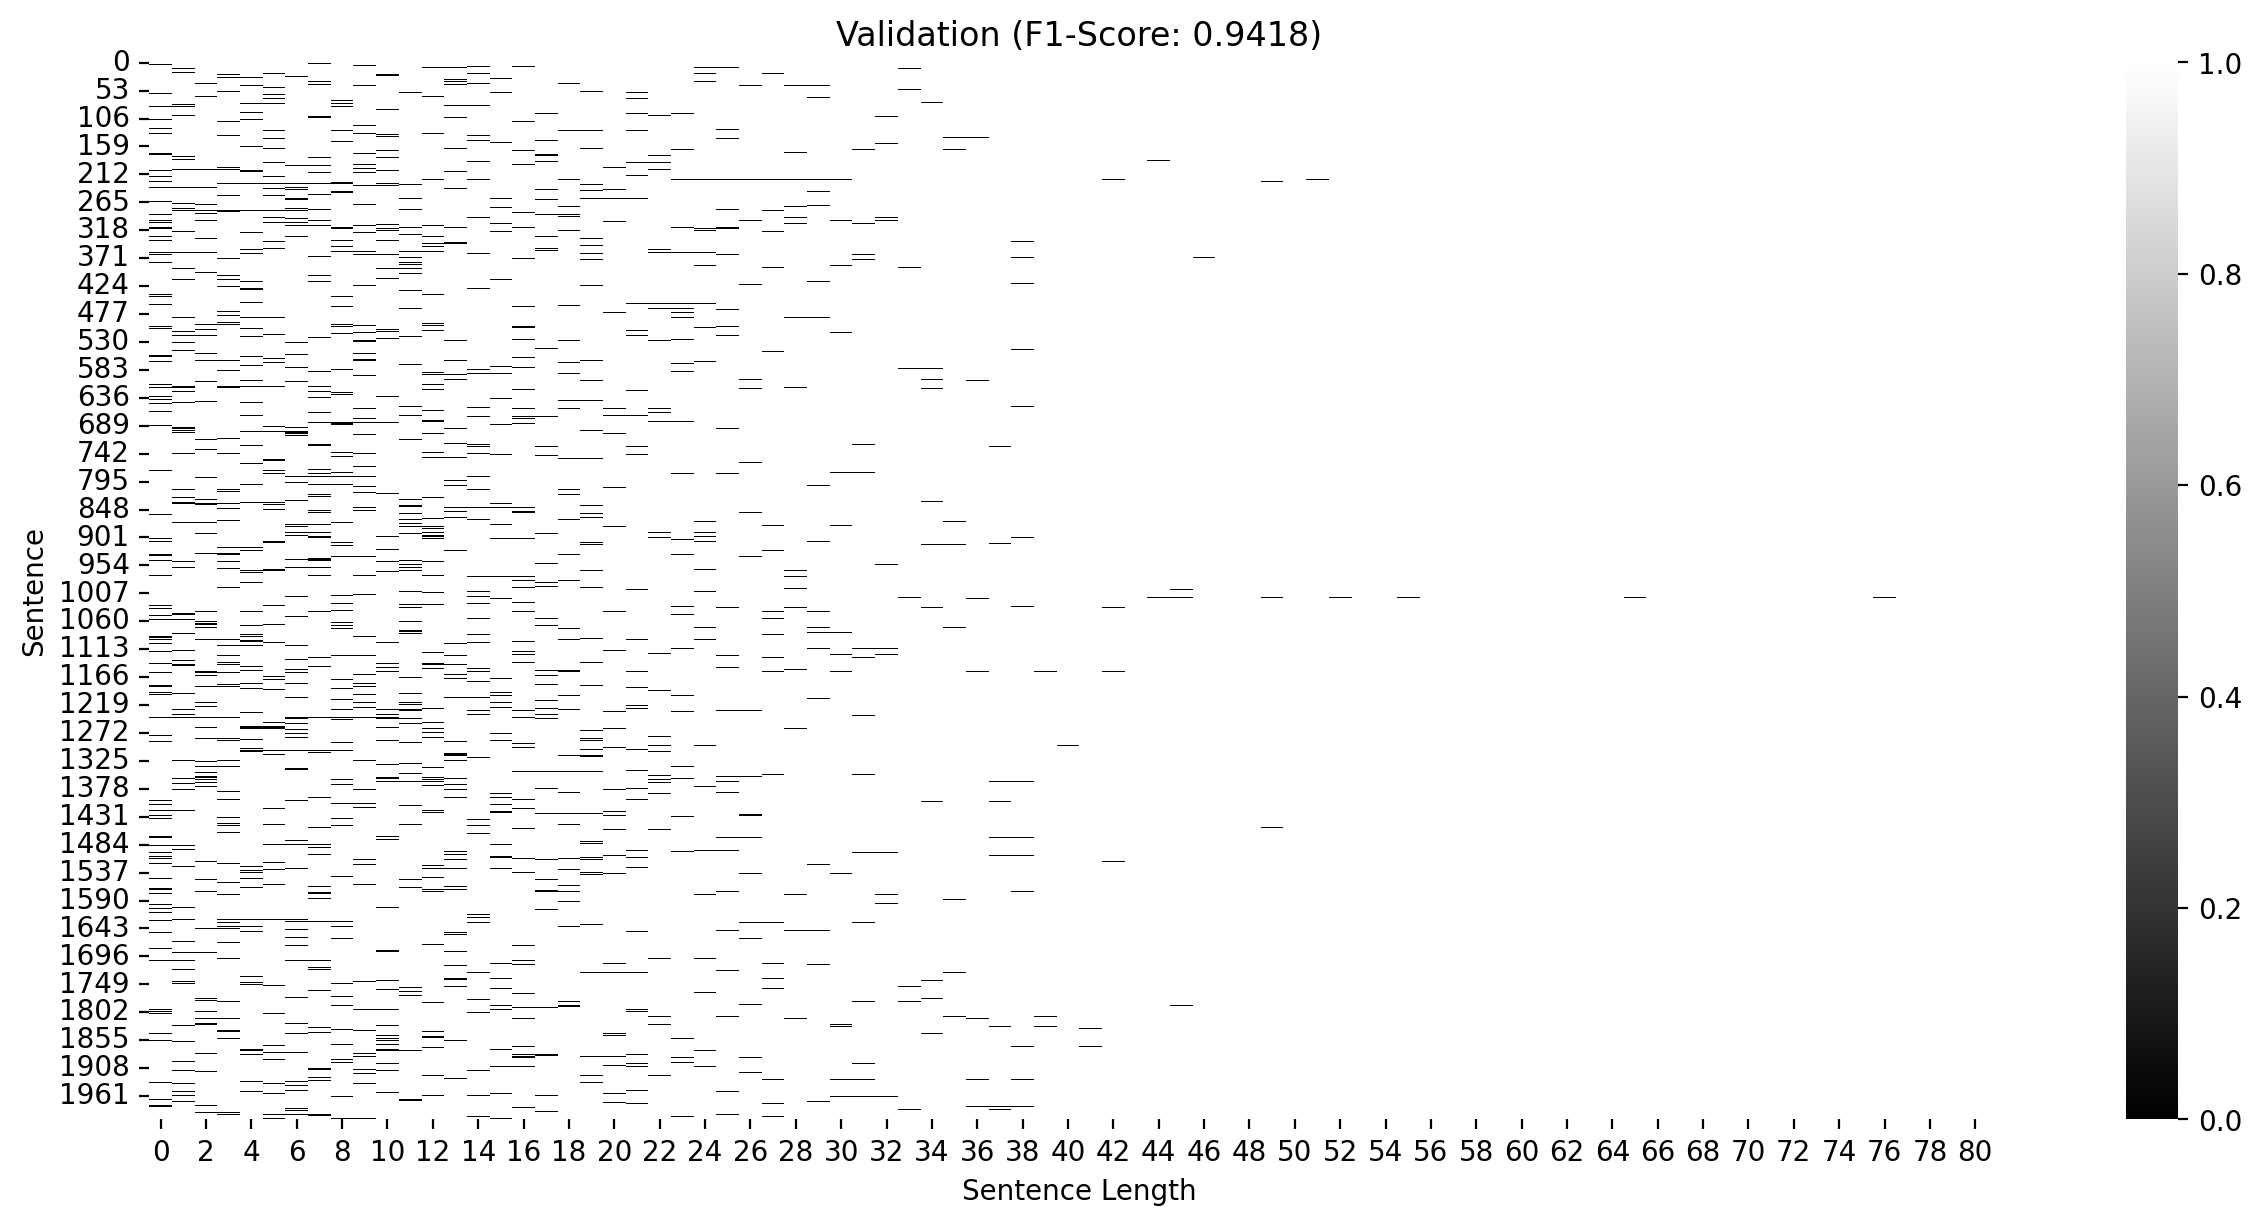

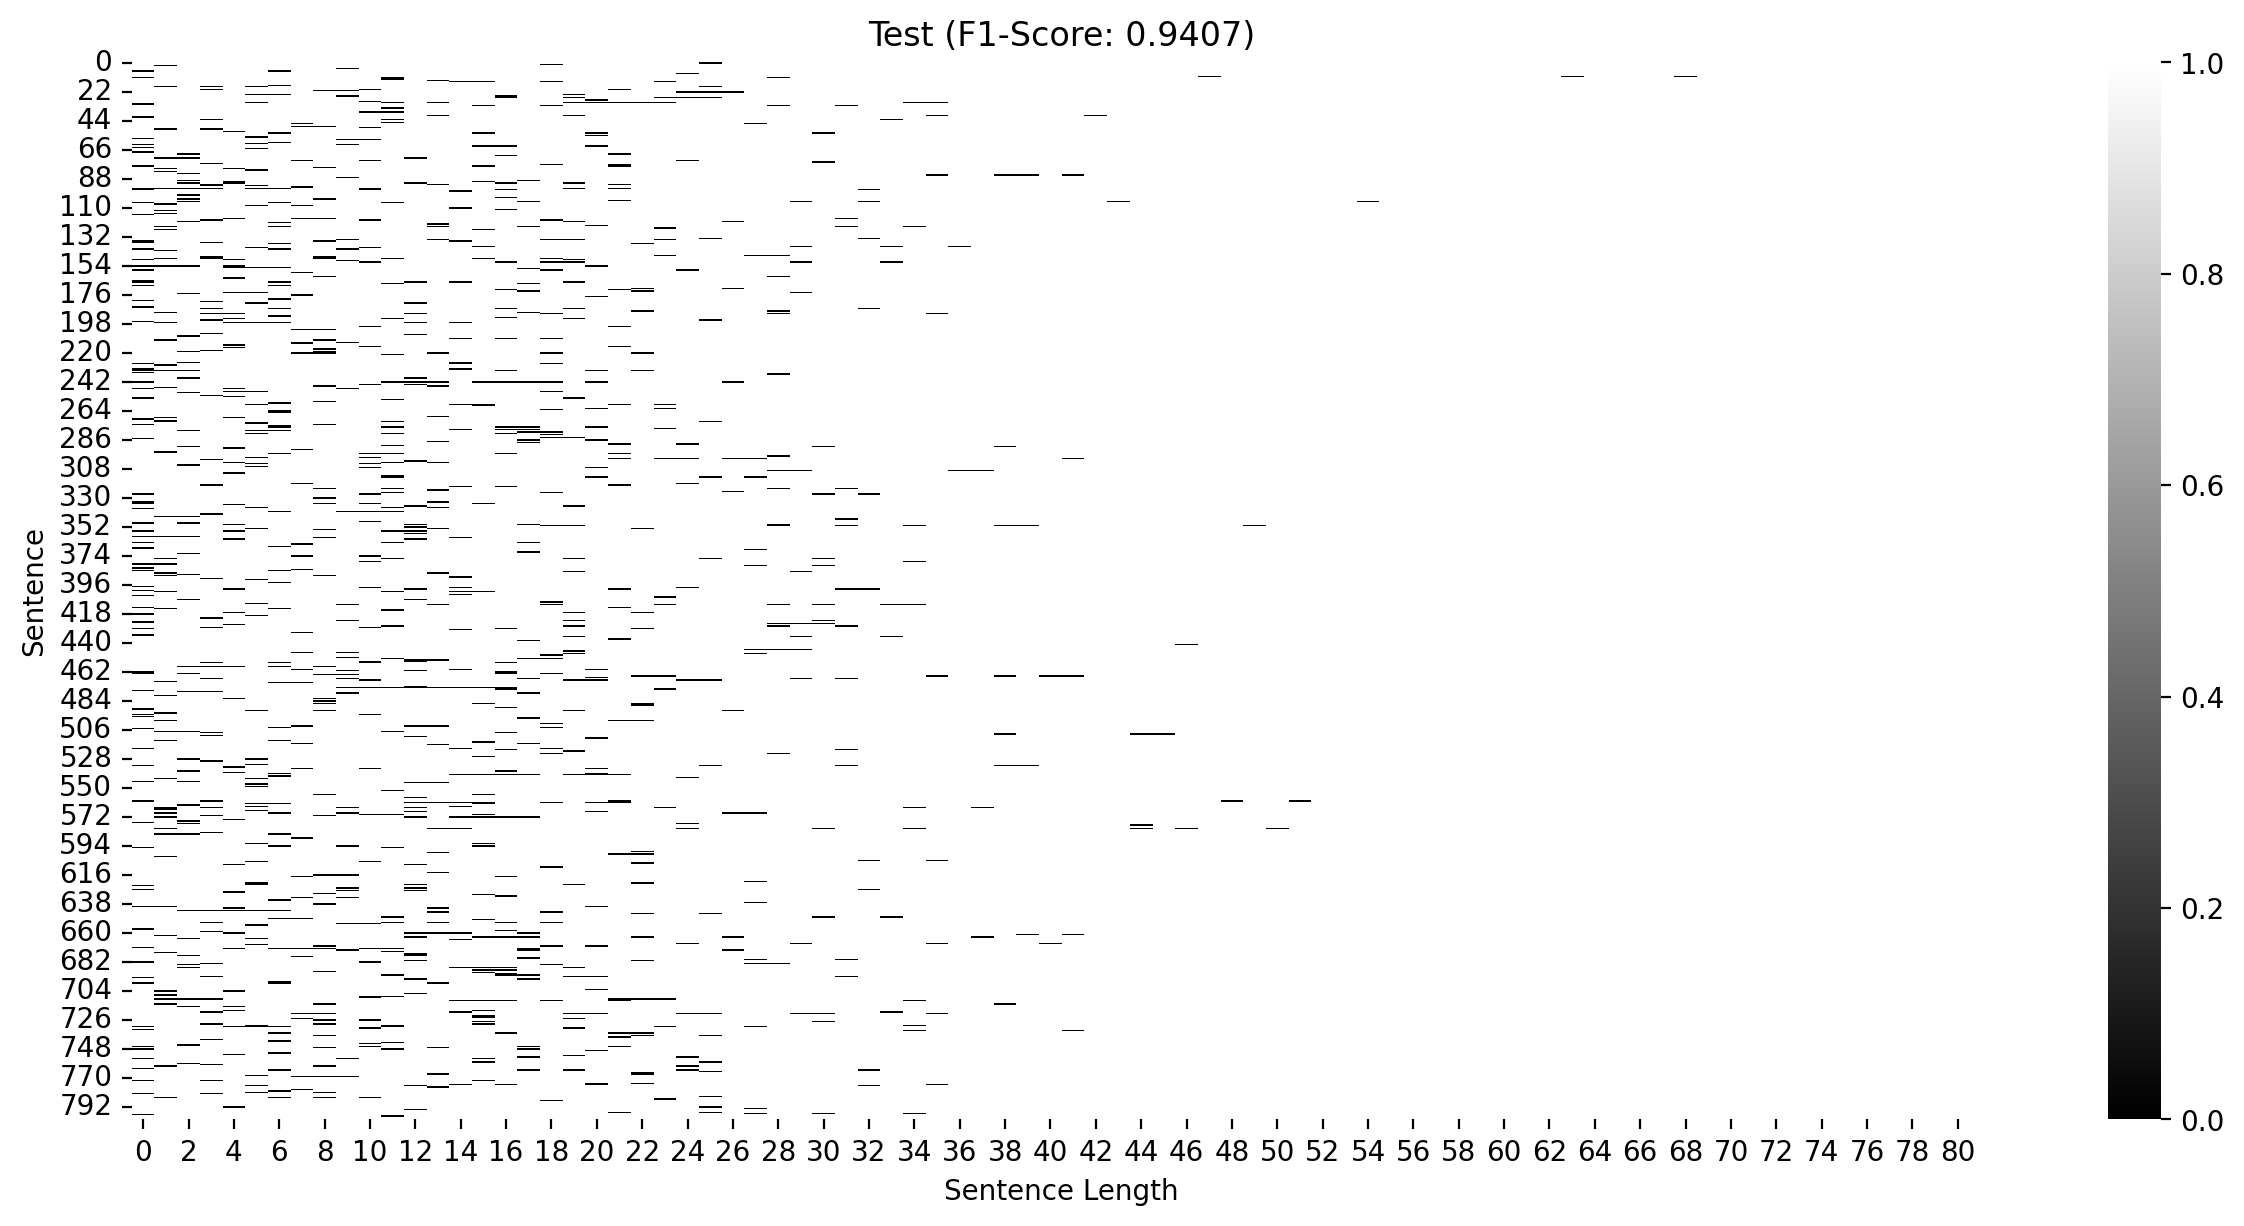

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 192 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


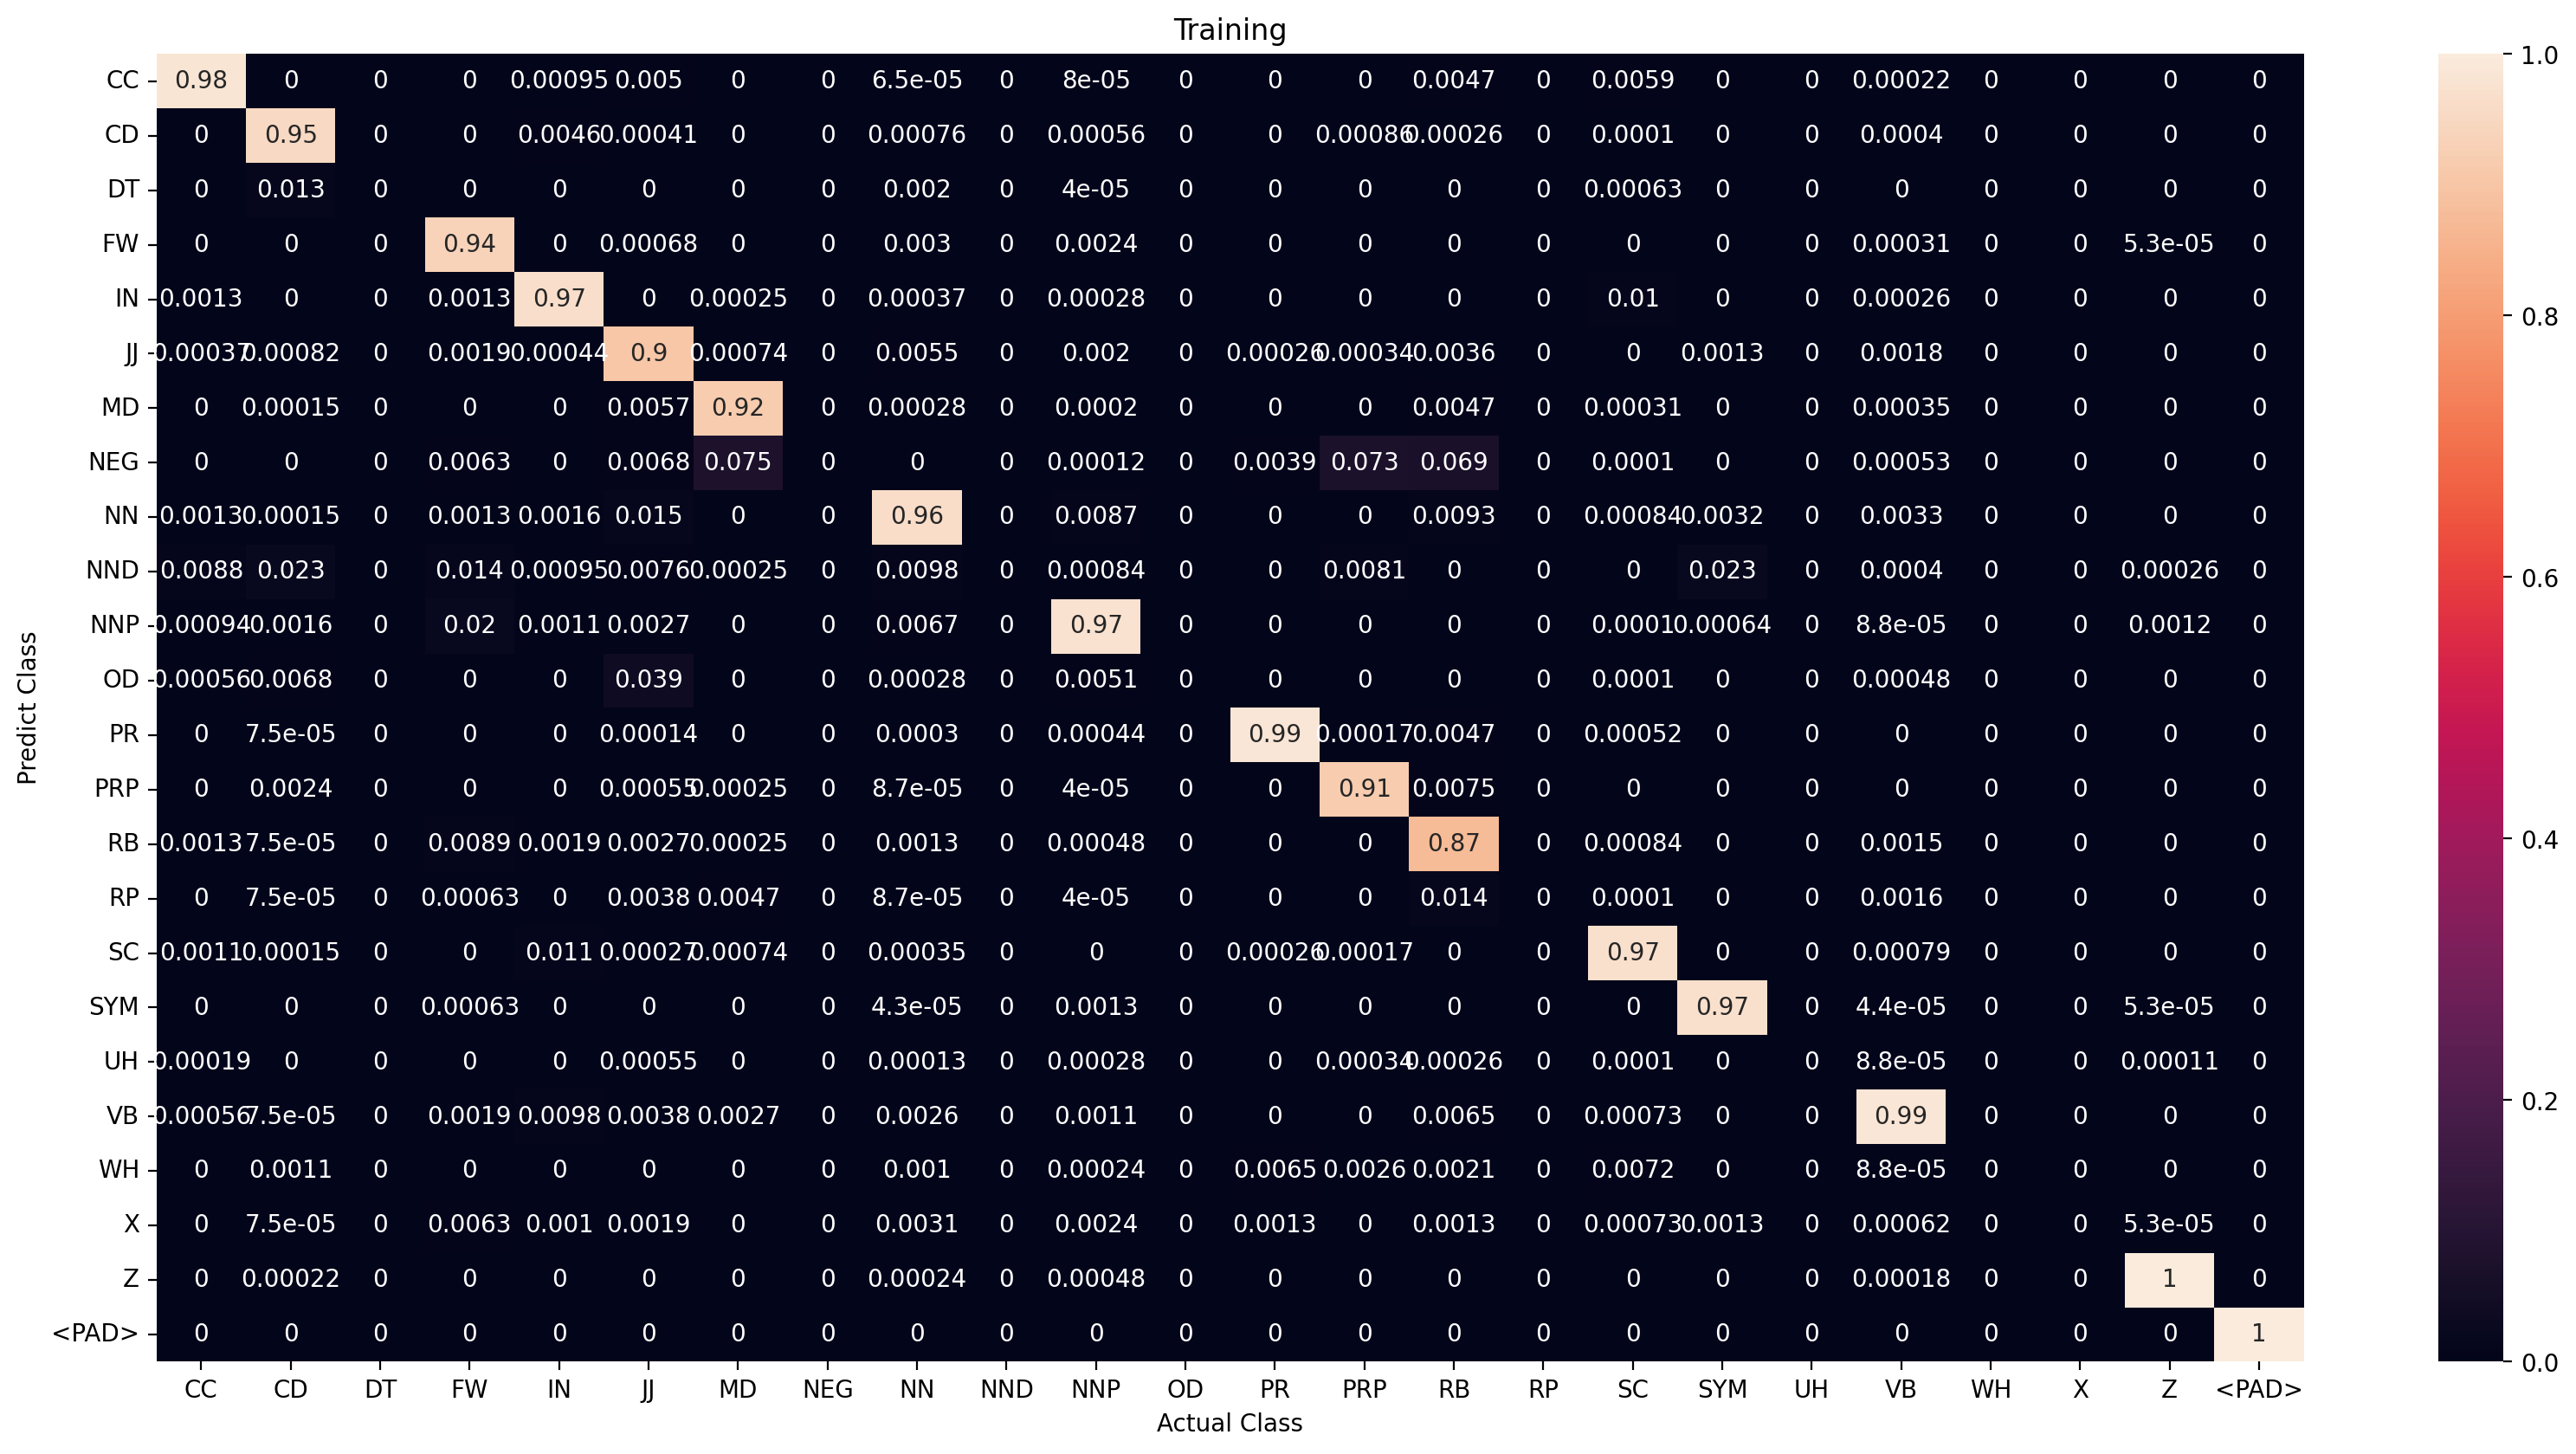

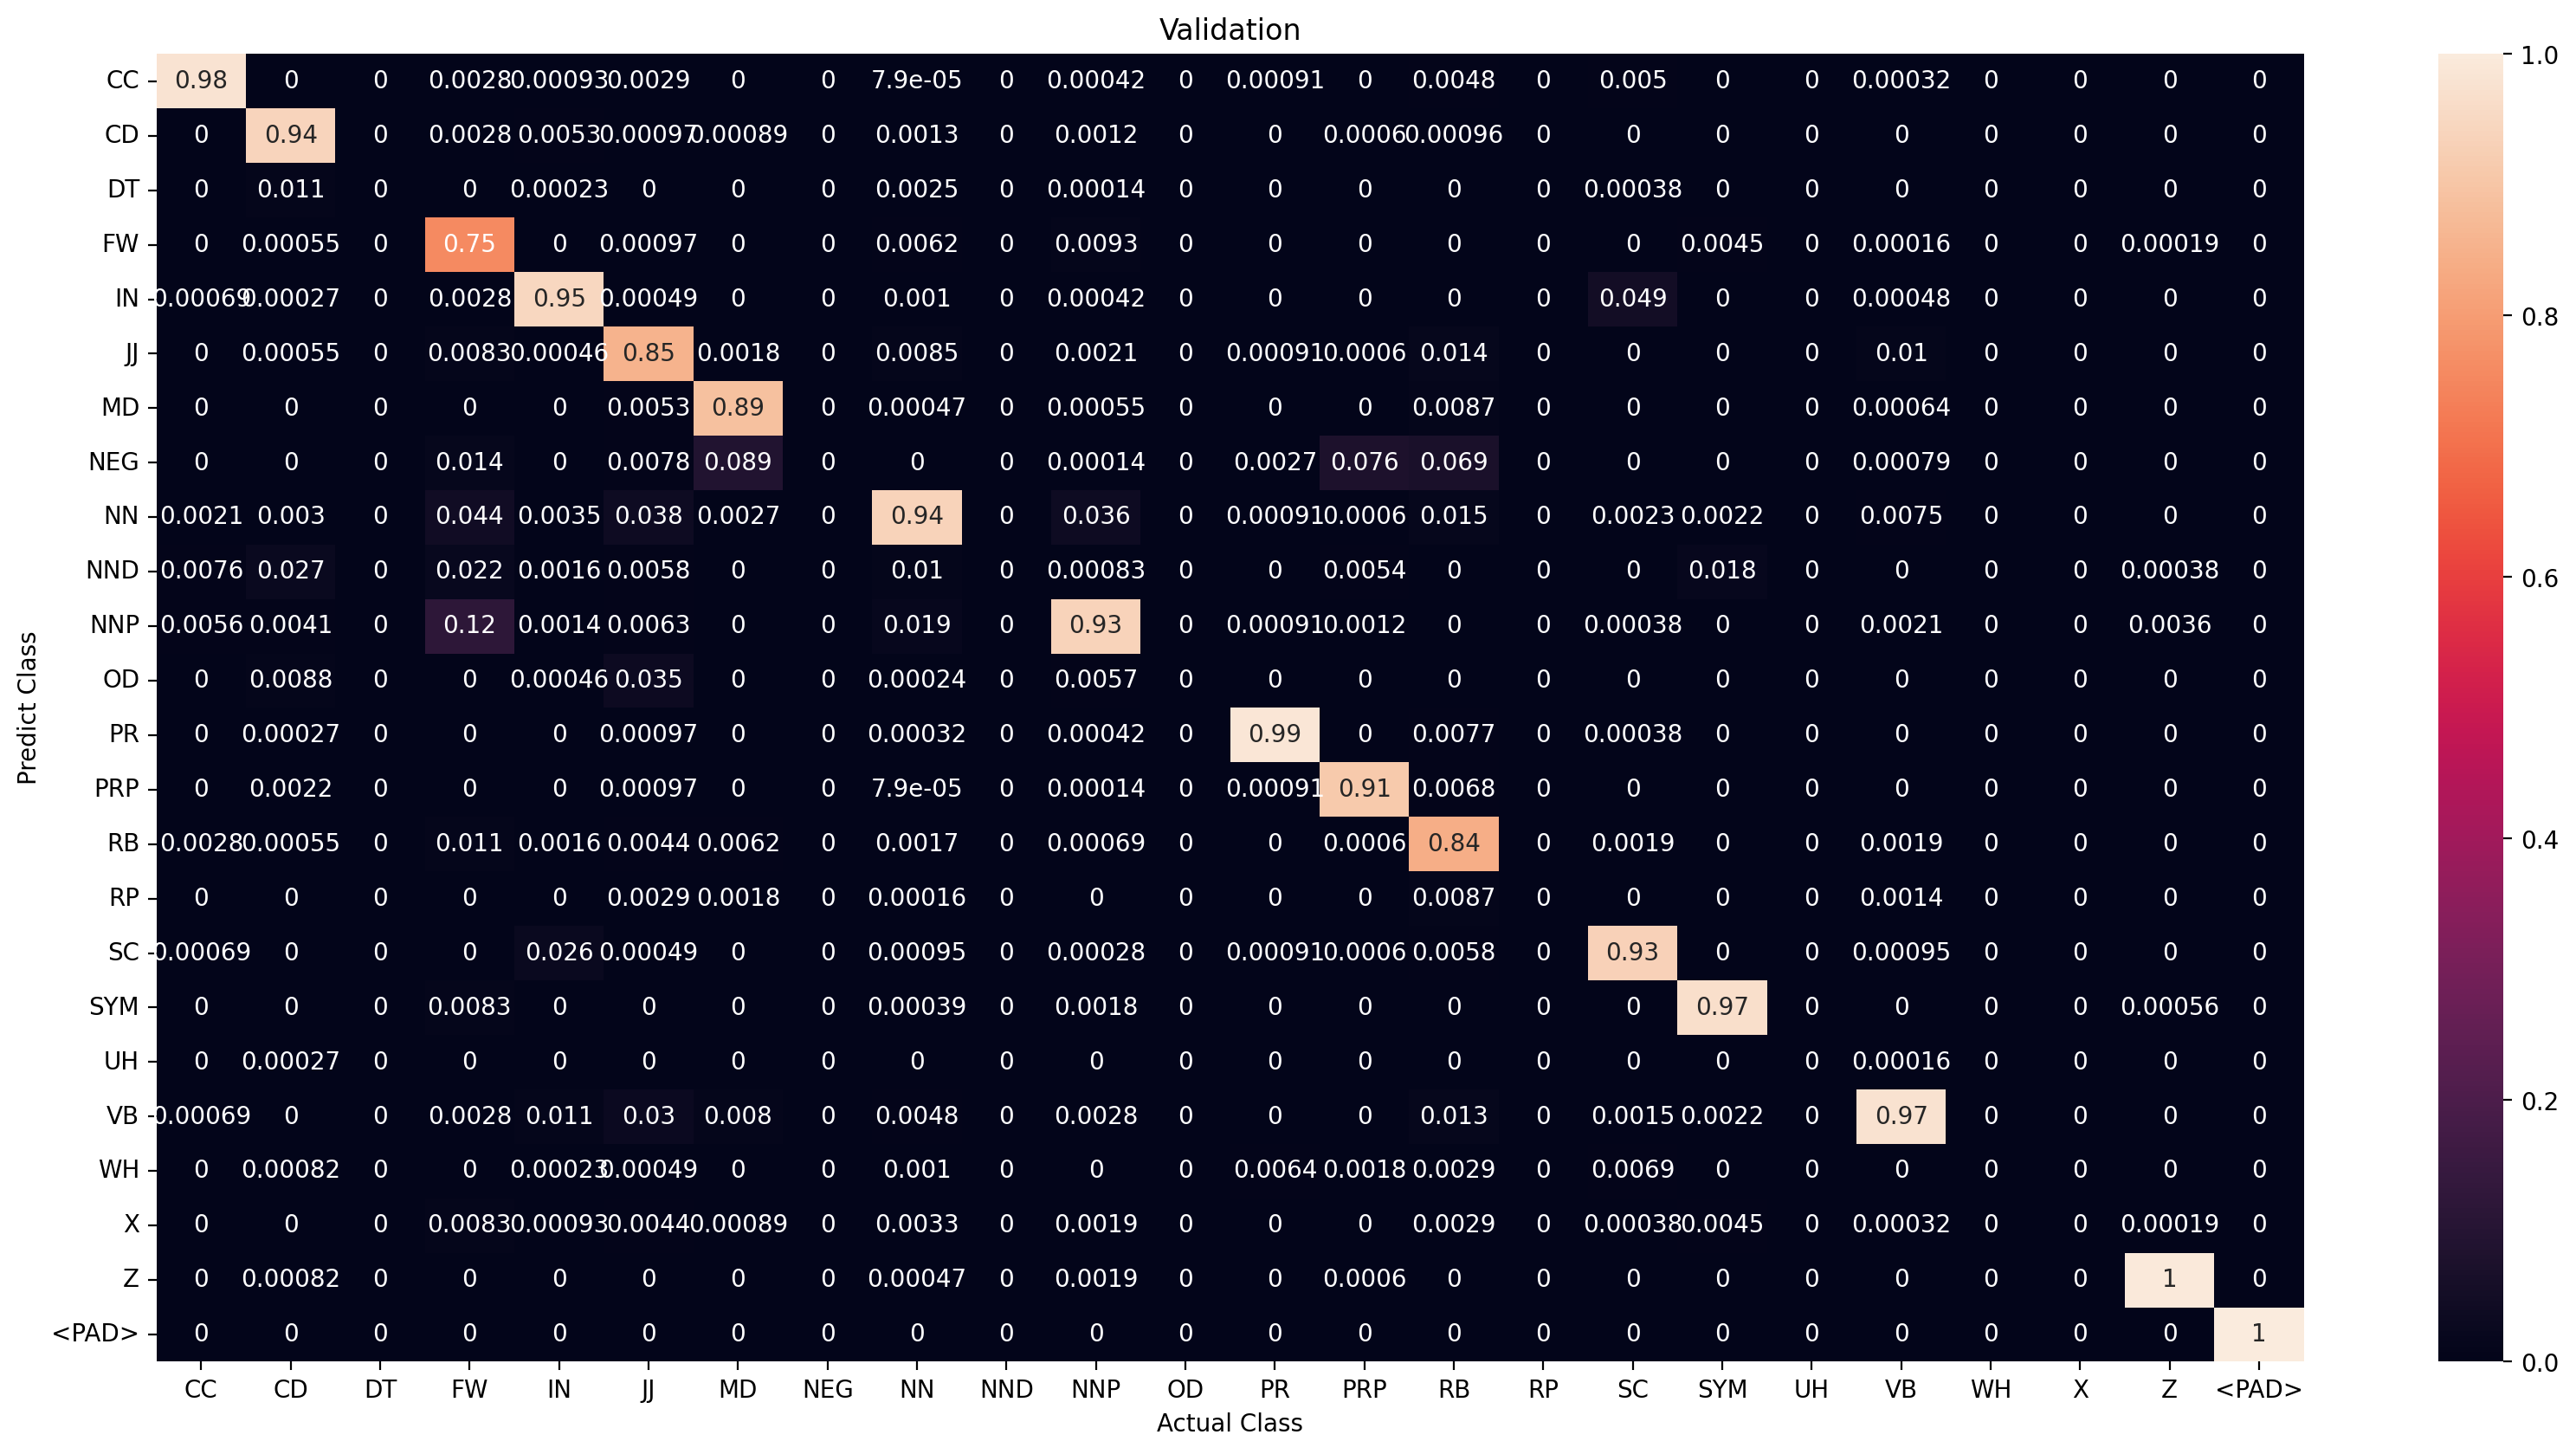

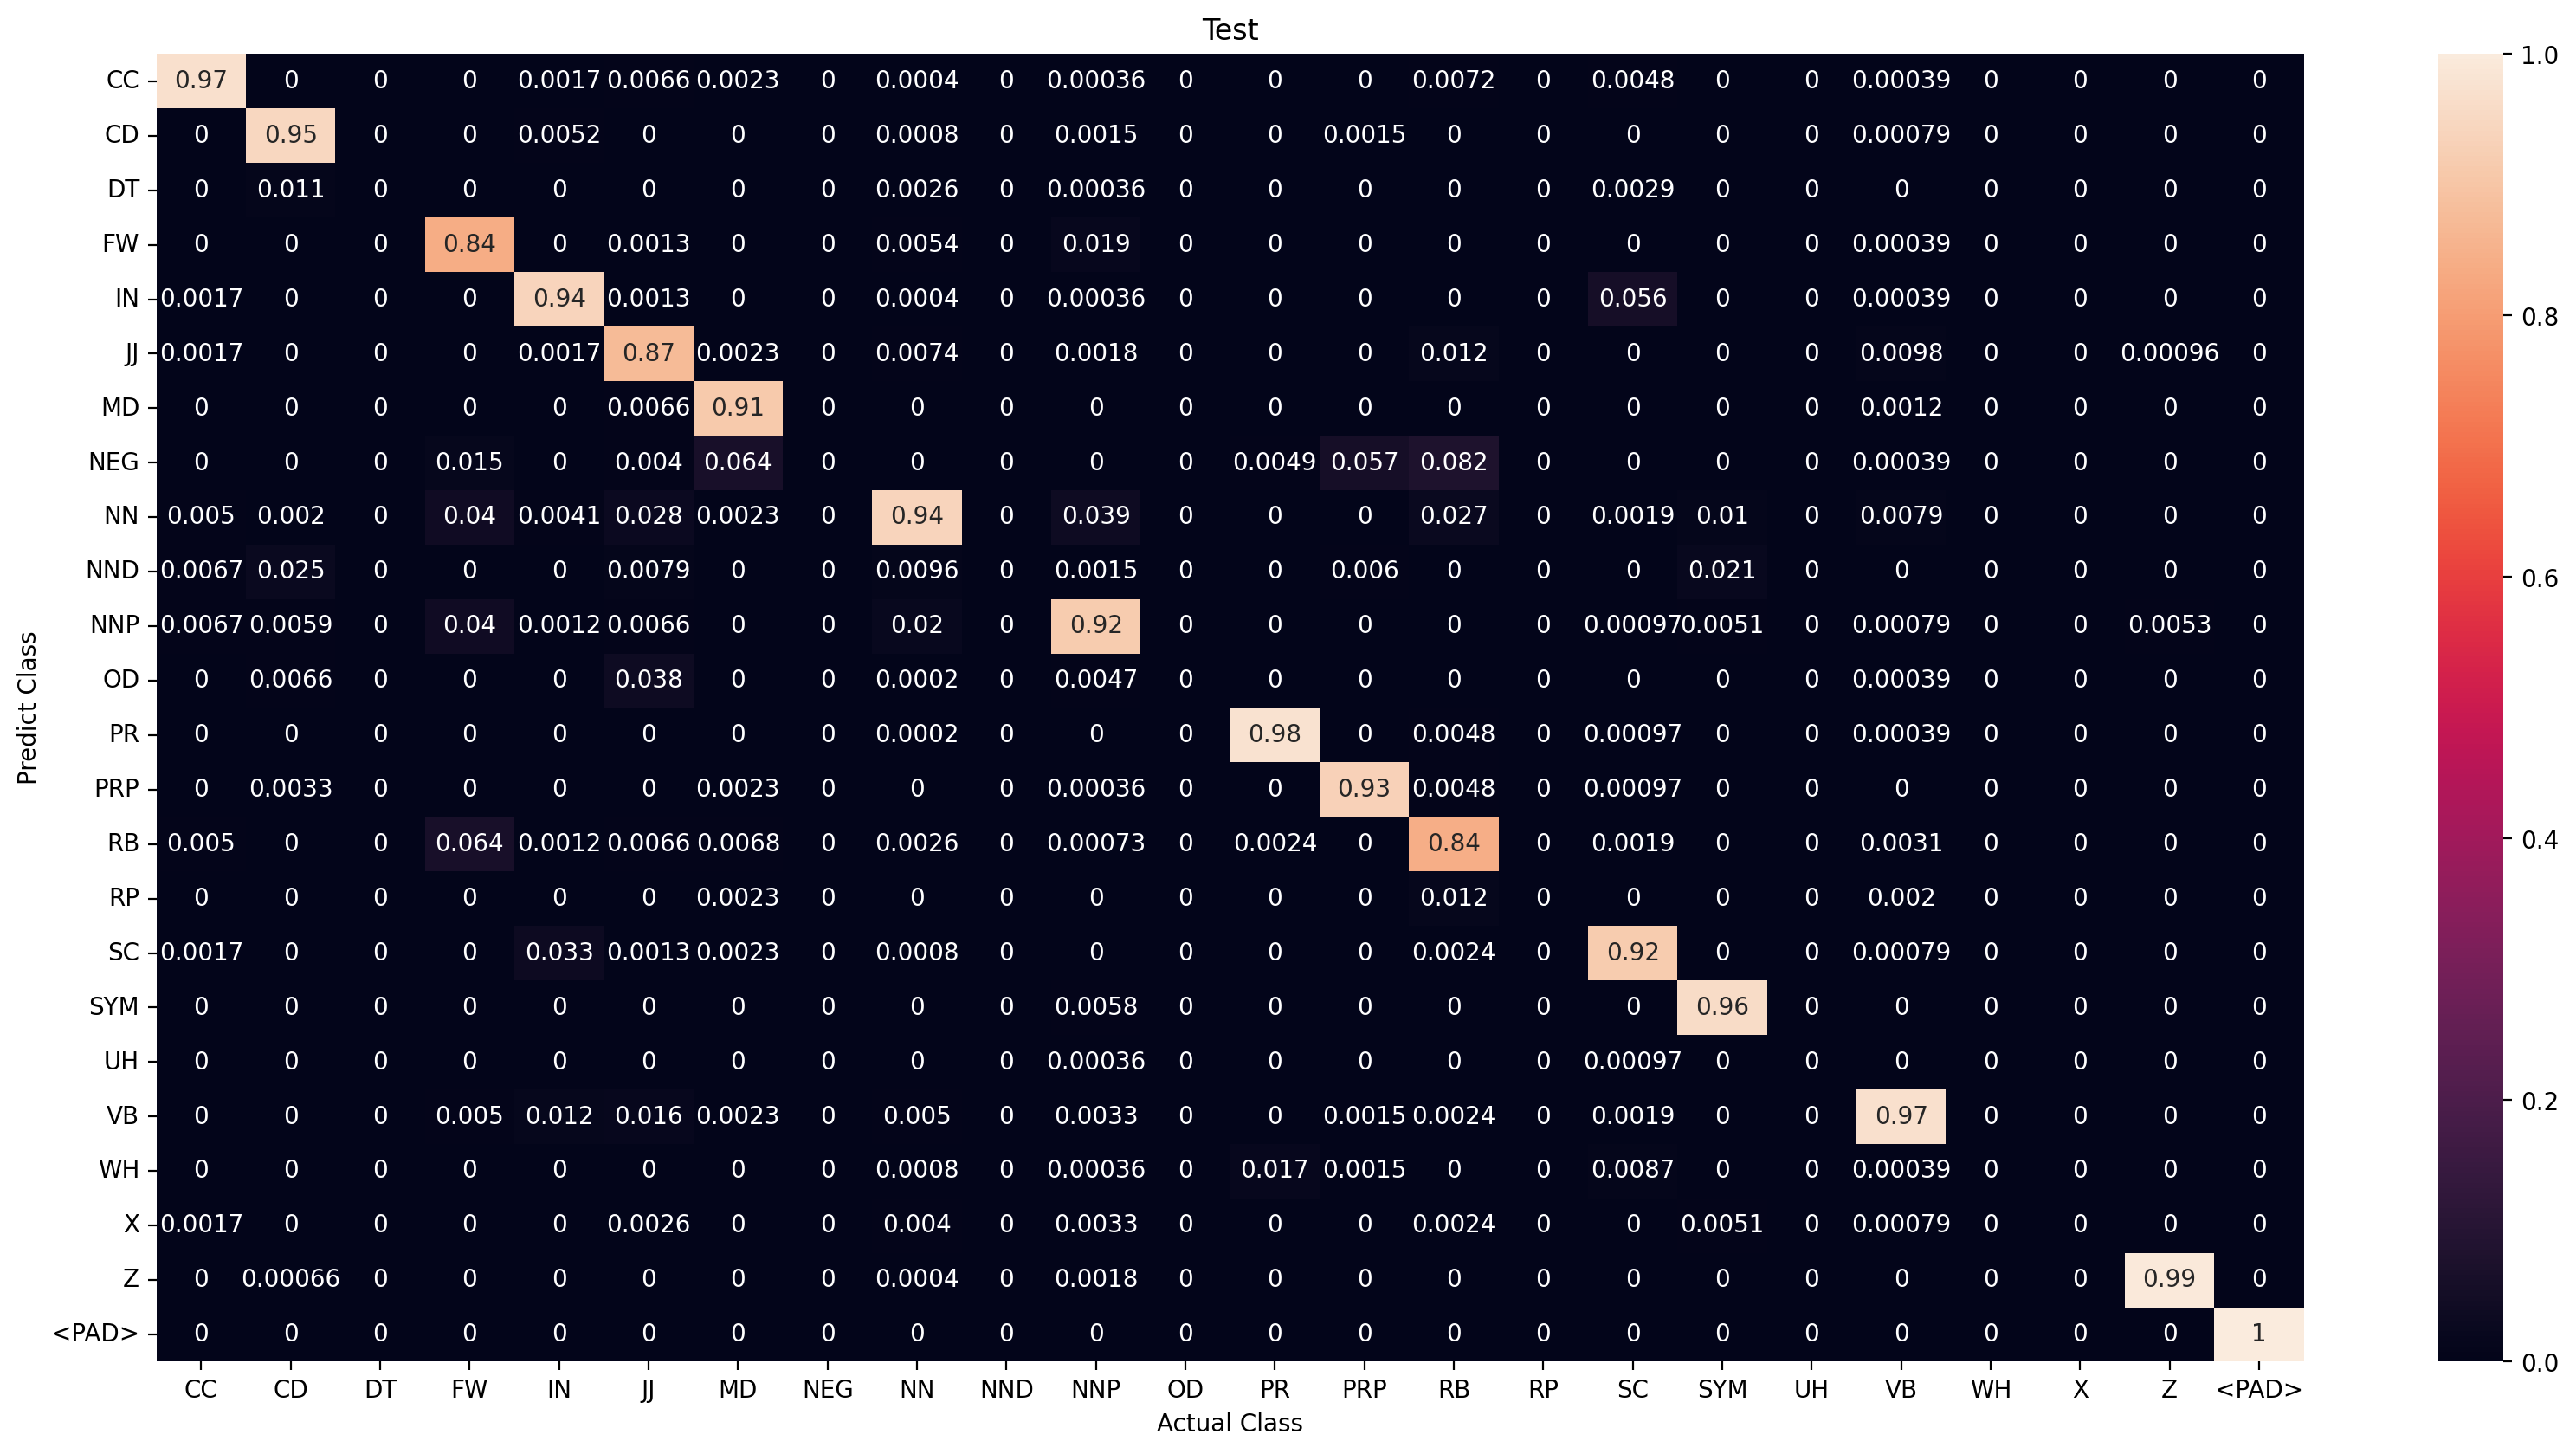

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5391   | CC    : 5255       | CC    : 136      |
| CD    : 12882  | CD    : 12741      | CD    : 141      |
| DT    : 273    | DT    : 0          | DT    : 273      |
| FW    : 1690   | FW    : 1480       | FW    : 210      |
| IN    : 15403  | IN    : 15268      | IN    : 135      |
| JJ    : 7018   | JJ    : 6631       | JJ    : 387      |
| MD    : 3810   | MD    : 3719       | MD    : 91       |
| NEG   : 1082   | NEG   : 0          | NEG   : 1082     |
| NN    : 44728  | NN    : 44242      | NN    : 486      |
| NND   : 1019   | NND   : 0          | NND   : 1019     |
| NNP   : 24885  | NNP   : 24457      | NNP   : 428      |
| OD    : 534    | OD    : 0          | OD    : 534      |
| PR    : 3842   | PR    : 3791       | PR    : 51       |
| PRP   : 5405   | PRP   : 5334       | PRP   : 71       |
| RB    : 3553   | RB    : 3363       | RB    : 190      |
| RP    : 144    | RP    : 0          | RP    : 144     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8,  5,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11808
Correct prediction          : 11109
Wrong prediction            : 699
Percentage correct oov pred : 94.08028455284553

Validation
Number OOV token            : 3395
Correct prediction          : 3003
Wrong prediction            : 392
Percentage correct oov pred : 88.45360824742268

Test
Number OOV token            : 1359
Correct prediction          : 1212
Wrong prediction            : 147
Percentage correct oov pred : 89.1832229580574



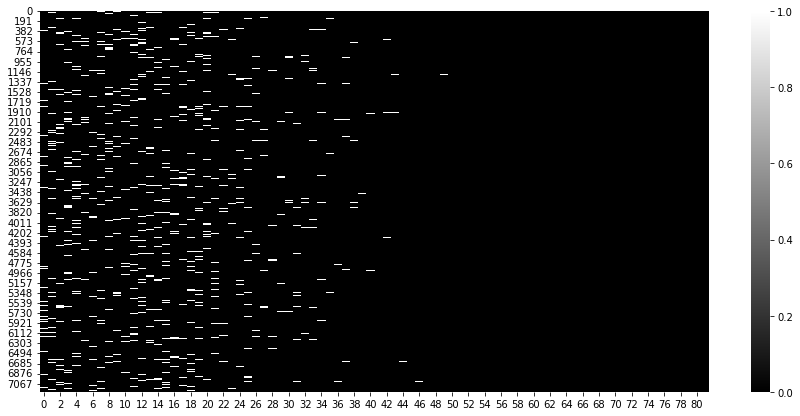

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

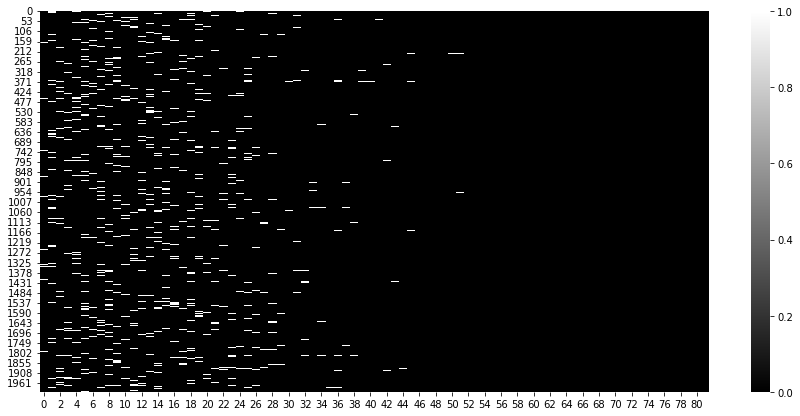

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

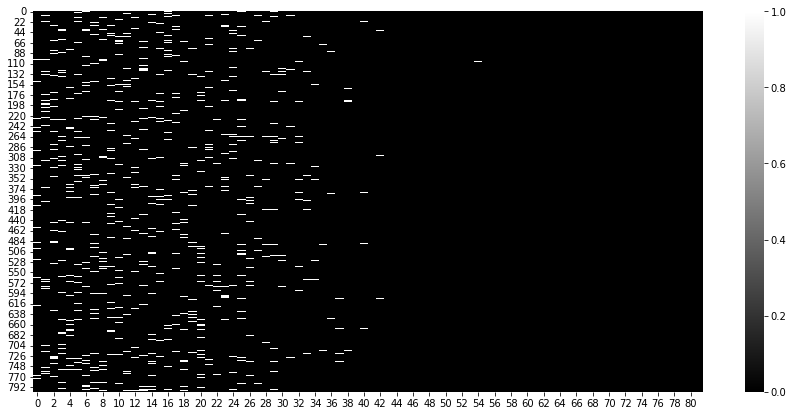

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);